# First Part

### Importing some basic libraries

In [301]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from tabulate import tabulate

### Getting the Canada data table from Wikipedia

In [302]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M") #GET Request to Wikipedia page
soup = BeautifulSoup(res.content,'lxml') 
table = soup.find_all('table')[0]  #Getting table from website
df = pd.read_html(str(table)) # Reading the table
df=df[0] #Getting the first object of list of tables (That's our Dataframe of interest)
df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


df=df[df['Borough'] != 'Not assigned'] #Excluding the Not Assigned Boroughs
#Since Wikipedia already has done the job for us of grouping Neighborhoods by Postal Codes we just need to replace '/' for ','
df['Neighborhood']=df['Neighborhood'].str.replace('/',',') 
df=df.reset_index(drop=True) #Reset index
df.head()

### Checking for Neighborhoods as Not Assigned

In [303]:
NONeighborhood= df[df['Neighborhood']=='Not assigned'] #Checking if there are Not assigned Neighborhoods
NONeighborhood
#No neighborhoods as Not assigned

,Postal code,Borough,Neighborhood


### The shape of our dataframe

In [304]:
df.shape

(180, 3)

# Second Part. Getting the lat and long

### Reading the csv file from url

In [305]:
coord_df=pd.read_csv("https://cocl.us/Geospatial_data")
coord_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Just Renaming the column to standarize

In [306]:
coord_df.rename(columns={'Postal Code':'Postal code'}, inplace=True)

### Merging both dataframes using the Postal code key as reference

In [307]:
final_df=pd.merge(df,coord_df, on='Postal code')
final_df['Neighborhood']=final_df['Neighborhood'].str.replace('/',',')# Processing de '/' as ','
final_df.sort_values(by='Postal code')
final_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


# Third Part. Analyzing the Neighborhoods

### Some basic libraries to work with

In [163]:
!pip install folium #Installing folium
!pip install geopy
import folium
from geopy.geocoders import Nominatim

### We will work just with the Boroughs that contain the word 'Toronto'

In [308]:
df=final_df[final_df['Borough'].str.contains("Toronto")] #Getting the Boroughs that contain the word Toronto
df.reset_index(inplace=True,drop=True) #Resetting index
df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Getting the Toronto's coordinates wit geopy

In [309]:
address = 'TORONTO, ONTARIO'

geolocator = Nominatim(user_agent="TORONTO_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of TORONTO are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of TORONTO are 43.6534817, -79.3839347.


### Now let's create the Neighborhoods map with Folium and mark them

In [310]:
#Creating map
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Setting up the credentials for Foursquare

In [334]:
# The code was removed by Watson Studio for sharing.

### Create a function to get Nearby Venues around all the Neighborhoods

In [287]:
from pandas.io.json import json_normalize
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now let's use it

In [311]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Regent Park , Harbourfront
Queen's Park , Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
The Danforth West , Riverdale
Toronto Dominion Centre , Design Exchange
Brockton , Parkdale Village , Exhibition Place
India Bazaar , The Beaches West
Commerce Court , Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park , The Junction South
North Toronto West
The Annex , North Midtown , Yorkville
Parkdale , Roncesvalles
Davisville
University of Toronto , Harbord
Runnymede , Swansea
Moore Park , Summerhill East
Kensington Market , Chinatown , Grange Park
Summerhill West , Rathnelly , South Hill , Forest Hill SE , Deer Park
CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport
Roseda

### Let's see our result

In [289]:
print(toronto_venues.shape)
toronto_venues.head()

(1612, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park , Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park , Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park , Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park , Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park , Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


### As a first step for preparing the data for a Clustering Analysis, we will create a one hot encoding for the Venue Category column on the toronto_venues dataframe

In [312]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

#Put Neighborhood column at first
fixed_columns= list(toronto_onehot)
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Now we get the mean frequency per Neighborhood

In [313]:
toronto_grouped= toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Business reply mail Processing CentrE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556
3,"CN Tower , King and Spadina , Railway Lands , ...",0.055556,0.055556,0.055556,0.111111,0.166667,0.111111,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.015873
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013889,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778
7,"Commerce Court , Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,...,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Now just for fun let's analyze the top5 venues per Neighborhood

In [314]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2          Restaurant  0.04
3  Italian Restaurant  0.04
4                Café  0.04


----Brockton , Parkdale Village , Exhibition Place----
            venue  freq
0            Café  0.14
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3       Pet Store  0.05
4       Nightclub  0.05


----Business reply mail Processing CentrE----
                venue  freq
0  Light Rail Station  0.11
1         Yoga Studio  0.06
2                 Spa  0.06
3       Garden Center  0.06
4              Garden  0.06


----CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport----
              venue  freq
0   Airport Service  0.17
1    Airport Lounge  0.11
2  Airport Terminal  0.11
3           Airport  0.06
4               Bar  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.21
1  Italian Restaurant  0.06
2  

### We define a function to get the most common venues and then use it to create a new dataframe

In [291]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [323]:
num_top_venues = 10 #Define the number of top results

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Italian Restaurant,Beer Bar,Restaurant,Café,Cheese Shop,Bakery,Seafood Restaurant,Farmers Market
1,"Brockton , Parkdale Village , Exhibition Place",Café,Breakfast Spot,Coffee Shop,Nightclub,Stadium,Bar,Intersection,Bakery,Italian Restaurant,Climbing Gym
2,Business reply mail Processing CentrE,Light Rail Station,Yoga Studio,Spa,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place,Recording Studio
3,"CN Tower , King and Spadina , Railway Lands , ...",Airport Service,Airport Lounge,Airport Terminal,Airport,Harbor / Marina,Coffee Shop,Plane,Rental Car Location,Sculpture Garden,Boat or Ferry
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Bubble Tea Shop,Burger Joint,Middle Eastern Restaurant,Japanese Restaurant,Salad Place,Ice Cream Shop


In [270]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Now we use the toronto_grouped dataframe to train a K-means using K's values from 1 to 20 and get the best one with the Elbow Method

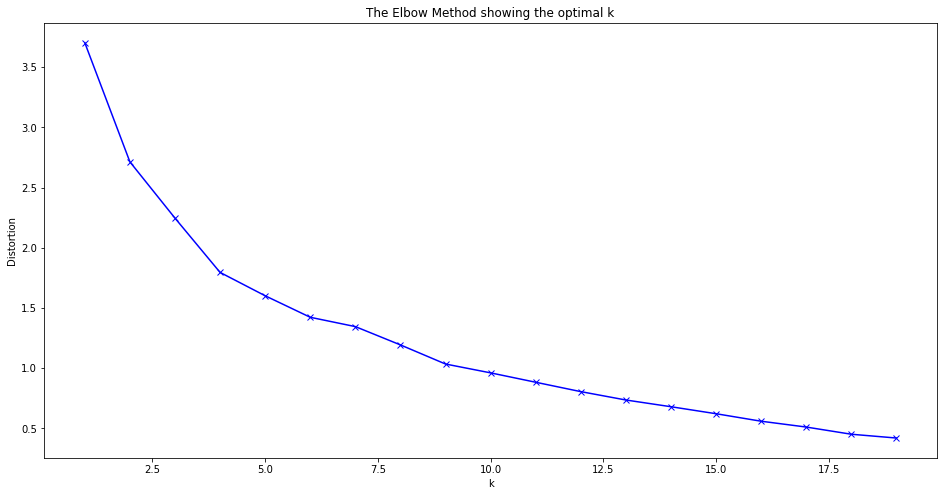

In [324]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)


distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()





In [325]:
print("Elbow point at k=9")
kmeans = KMeans(n_clusters=9, random_state=0).fit(toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

Elbow point at k=9


array([0, 0, 0, 4, 0, 0, 0, 0, 0, 8], dtype=int32)

### To visualize better the labels, let's add them to the sorted venues dataframe

In [326]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Theater,Mexican Restaurant,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Creperie,Beer Bar,Sandwich Place,Burger Joint,Burrito Place,Café
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Café,Restaurant,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Middle Eastern Restaurant,Diner,Ramen Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Gastropub,Cocktail Bar,American Restaurant,Italian Restaurant,Art Gallery,Seafood Restaurant,Clothing Store,Moroccan Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,5,Trail,Health Food Store,Pub,Yoga Studio,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


### Now let's plot them in a map

In [265]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [333]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, 11))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters